In [2]:
import numpy as np
np.random.seed(123)  # for reproducibility
 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K

K.set_image_dim_ordering('th')
 
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
 
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)
 
# 7. Define model architecture
model = Sequential()
 
model.add(Convolution2D(32, 3, 3, activation='relu', input_shape=(1,28,28)))
model.add(Convolution2D(32, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
 
# 8. Compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
 
# 9. Fit model on training data
model.fit(X_train, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)
 
# 10. Evaluate model on test data
score = model.evaluate(X_test, Y_test, verbose=0)


C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:31: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(1, 28, 28..., activation="relu")`
C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu")`
C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
60000/60000 [==============================] - 36s 604us/step - loss: 0.2014 - acc: 0.9377
Epoch 2/10
60000/60000 [==============================] - 35s 588us/step - loss: 0.0841 - acc: 0.9748
Epoch 3/10
60000/60000 [==============================] - 40s 665us/step - loss: 0.0649 - acc: 0.9805
Epoch 4/10
60000/60000 [==============================] - 34s 573us/step - loss: 0.0533 - acc: 0.9832
Epoch 5/10
60000/60000 [==============================] - 34s 561us/step - loss: 0.0435 - acc: 0.9866
Epoch 6/10
60000/60000 [==============================] - 36s 594us/step - loss: 0.0408 - acc: 0.9876
Epoch 7/10
60000/60000 [==============================] - 36s 596us/step - loss: 0.0349 - acc: 0.9884
Epoch 8/10
60000/60000 [==============================] - 34s 563us/step - loss: 0.0326 - acc: 0.9898
Epoch 9/10
60000/60000 [==============================] - 34s 564us/step - loss: 0.0306 - acc: 0.9907
Epoch 10/10
60000/60000 [==============================] - 34s 564us/step - loss: 

In [22]:
from keras.models import load_model
model.save('keras_mnist_modelv1.h5')

In [1]:
from keras.models import load_model
import numpy as np
model = load_model('keras_mnist_modelv1.h5')
print(np.array(model.layers[-1].get_weights()[0]).shape)

C:\Users\Thomas\Anaconda3\envs\tensorflowgpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(128, 10)


(128, 10)


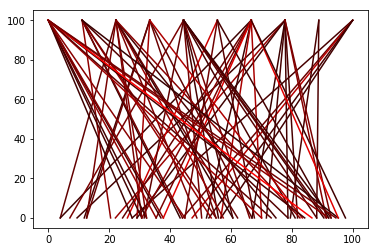

In [39]:
def floats_to_rgb(float_array):
    max_val = np.max(float_array)
    min_val = np.min(float_array)
    avg = (max_val + min_val)/2.0
    avg_array = np.ones(float_array.shape)*avg
    zero_array = np.zeros(float_array.shape)
    min_array = np.ones(float_array.shape)*min_val
    red = (np.where(float_array>avg, float_array, avg_array)-avg_array)/(max_val-avg)
#     blue = (avg_array-np.where(float_array<avg, float_array,avg_array))/(avg-min_val)
    blue = zero_array
#     green = (avg-min_val-abs(float_array-avg_array))/(avg-min_val)
    green = zero_array
    return np.dstack([red, green, blue])
    
# test = np.array([2.0,4.0,3.4,6.4])
# print([x for x in floats_to_rgb(test)])
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
thresh = np.percentile(weights, 94)
print(weights.shape)
weights[weights<thresh] = 0
colors = floats_to_rgb(weights)

from matplotlib import pyplot as plt
%matplotlib inline

# thresh = np.average(np.abs(np.array(model.layers[-1].get_weights()[0])))*2

x0 = np.linspace(0,100,128)
x1 = np.linspace(0,100,10)
y0 = 0
y1 = 100

for x, row in enumerate(colors):
    for y, rgb in enumerate(row):
        if abs(np.array(model.layers[-1].get_weights()[0])[x,y])>thresh:
            plt.plot([x0[x],x1[y]],[y0,y1], color=rgb)

plt.show()

In [2]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 26, 26)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 24, 24)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 12, 12)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 12, 12)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4608)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               589952    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [78]:
weights = model.get_weights()
print(weights[-2].shape)
thresh = np.percentile(np.abs(weights[-2]), 20)
weights[-2][np.abs(weights[-2])<thresh] = 0.0
config = model.get_config()
from keras.models import Sequential
model2 = Sequential.from_config(config)
model2.set_weights(weights)
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

(128, 10)


In [18]:

from keras.datasets import mnist
from keras.utils import np_utils
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data

X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
# 6. Preprocess class labels
Y_train = np_utils.to_categorical(y_train, 10)
Y_test = np_utils.to_categorical(y_test, 10)

In [ ]:
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

score = model2.evaluate(X_test, Y_test, verbose=0)
print(score)

In [3]:
def salt_pepper(im,ps=.1,pp=.1):
    im1=im[:,:].copy()
    n,m=im1.shape
    for i in range(n):
        for j in range(m):
            b=np.random.uniform()
            if b<ps:
                im1[i,j]=0
            elif b>1-pp:
                im1[i,j]=1
    noisy_im=im1
    return noisy_im
print(X_train.shape)
# add noise
X_train_noise = np.array([salt_pepper(X_train[i,0,:,:]) for i in range(X_train.shape[0])])
print(X_train_noise.shape)

(60000, 1, 28, 28)
(60000, 28, 28)


In [4]:
X_train_noise = np.reshape(X_train_noise,[60000,1,28,28])

(60000, 1, 28, 28)


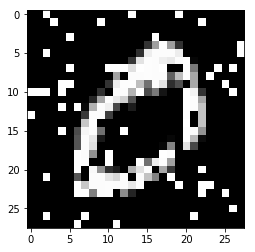

In [98]:
print(X_train_noise.shape)
plt.imshow(X_train_noise[1][0], cmap="gray")

In [5]:
config = model.get_config()
from keras.models import Sequential
model3 = Sequential.from_config(config)
# 8. Compile model
model3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# 9. Fit model on training data
model3.fit(X_train_noise, Y_train, 
          batch_size=32, nb_epoch=10, verbose=1)
 
# 10. Evaluate model on test data
score = model3.evaluate(X_test, Y_test, verbose=0)
from keras.models import load_model
model.save('keras_mnist_model_noisev1.h5')

NameError: name 'Sequential' is not defined

In [101]:
print(X_test.shape)
# add noise
X_test_noise = np.array([salt_pepper(X_test[i,0,:,:]) for i in range(X_test.shape[0])])
X_test_noise = np.reshape(X_test_noise,[10000,1,28,28])
print(X_test_noise.shape)

(10000, 1, 28, 28)
(10000, 1, 28, 28)


In [3]:
from keras.models import load_model
model3 = load_model('keras_mnist_model_noisev1.h5')

In [4]:
# 10. Evaluate model on test data
score = model.evaluate(X_test_noise, Y_test, verbose=0)
print(score)
score = model3.evaluate(X_test_noise, Y_test, verbose=0)
print(score)

NameError: name 'X_test_noise' is not defined

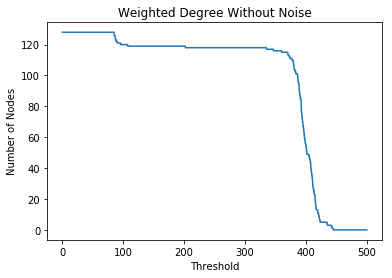

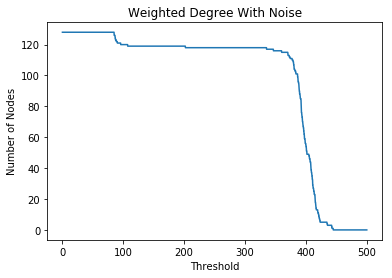

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
# function counting the number of nodes above a threshold
def thresh_count(arr, thresh):
    return(np.sum(arr > thresh))


def plot_l1_norm(model, title=""):
    # get the dense layer
    dense_layer= model.layers[-3]

    # pull out the weights
    dense_weights = np.array(dense_layer.get_weights())

    # compute the L1 norm for the dense weights
    dense_L1 = np.sum(np.abs(dense_weights[0]), axis = 0)

    # list of thresholds
    thresh_list = np.linspace(0,500, 2000)

    # count the number of nodes for all thresholds
    dense_count = np.array([thresh_count(dense_L1, thresh) for thresh in thresh_list])

    # plot count vs. thresh
    plt.plot(thresh_list, dense_count)
    plt.xlabel("Threshold")
    plt.ylabel("Number of Nodes")
    plt.title(title)
    plt.show()
    
plot_l1_norm(model, title="Weighted Degree Without Noise")
plot_l1_norm(model3, title="Weighted Degree With Noise")

In [2]:
weights = np.abs(np.array(model.layers[-1].get_weights()[0]))
print(weights.shape)
weight_adj_matrix = np.zeros([sum(weights.shape),sum(weights.shape)])
weight_adj_matrix[weights.shape[0]:,:weights.shape[0]] = np.transpose(weights)


(128, 10)


In [27]:
import bct
bct.betweenness_wei(weight_adj_matrix)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [3]:
def weighted_clustering_coeff(G):
    """ Calculates clustering coefficient for a weighted network represented by an adjacency matrix """
    # https://www.researchgate.net/publication/49721057_Competition_for_Popularity_in_Bipartite_Networks
    k = G.shape[0] # assume fully connected
    coeffs = np.zeros((k,))
    for i in range(k):
        for j in range(k):
            for h in range(k):
                coeffs[i] += (G[i,j]*G[i,h]*G[h,j])**(1.0/3.0)
        Gv = np.max(G[i,:])
        coeffs[i] *= 2.0/(k*(k-1)*Gv)
    return coeffs

def calc_clustering_coeff_square(weights):
    """ Calculates clustering coefficients for a bipartite weighted network represented by a weight matrix """
    # Compute the unipartite networks correspondign to the bipartite network
    adj1 = np.matmul(weights, np.transpose(weights))
    adj2 = np.matmul(np.transpose(weights), weights)
    return weighted_clustering_coeff(adj1), weighted_clustering_coeff(adj2)

coeffs1, coeffs2 = calc_clustering_coeff_square(weights)

print(coeffs1)
print(coeffs2)

[1.34057611 1.50929653 1.73605064 1.19731262 1.21102299 1.14816974
 1.34676438 1.32896723 1.11015616 1.32267434 1.24690514 1.37216327
 1.2618905  1.58620752 1.36436365 1.25307896 1.0651853  1.34867898
 1.3329485  1.19433681 1.33923586 1.20956296 1.14357654 1.15410609
 1.24276211 1.40917349 1.16005138 1.26479179 1.12942346 1.31852542
 1.34208809 1.10928271 1.34256744 1.19474112 1.09693357 1.21969238
 1.33213253 1.16233619 1.35825865 0.99936869 1.411696   1.07375474
 1.33125376 1.16354931 1.58182676 1.0077414  1.25371257 1.07120339
 0.96135188 1.15632041 1.16282898 1.21361514 1.13190723 1.28605185
 1.32902381 1.29287965 1.19192672 1.07087063 1.36577335 1.3291784
 1.21573007 1.20185324 1.07382408 1.36950737 1.30892518 1.25571976
 1.1071466  1.24970833 1.1947265  1.2443683  1.1305623  1.20260526
 1.10690225 1.21118867 1.18741045 1.15627933 1.18112905 1.24582391
 1.44560972 1.13710016 1.42113953 1.12928808 1.40018532 1.44986259
 1.35788285 1.08306589 1.09742208 1.06305242 1.35042668 0.95475

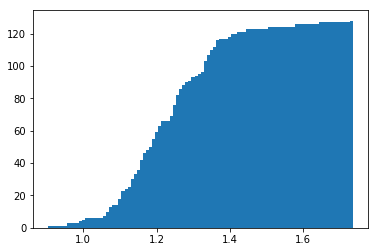

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

coeffs1, coeffs2 = calc_clustering_coeff_square(weights)
plt.hist(coeffs1, bins=100, cumulative=True)
plt.show()
# coeffs1, coeffs2 = calc_clustering_coeff_square(weights_noise)
# plt.hist(coeffs1, bins=100, cumulative=True)
# plt.show()

In [3]:
# Compute the adjacency matrix of the layer
layer_adj_matrix = np.matmul(weights, np.transpose(weights))
print(layer_adj_matrix)

[[0.48281583 0.13003856 0.12423163 ... 0.36131796 0.43616673 0.31289464]
 [0.13003856 0.10315547 0.06657131 ... 0.1340848  0.20803358 0.14207378]
 [0.12423163 0.06657131 0.0603534  ... 0.10946285 0.1740945  0.11754135]
 ...
 [0.36131796 0.1340848  0.10946285 ... 0.33651704 0.38376465 0.2618209 ]
 [0.43616673 0.20803358 0.1740945  ... 0.38376465 0.59713423 0.39562884]
 [0.31289464 0.14207378 0.11754135 ... 0.2618209  0.39562884 0.3243383 ]]


In [4]:
# Find the highest activation image for each node in the first dense layer
from keras.utils import np_utils
from keras.datasets import mnist
from keras import backend as K

K.set_image_dim_ordering('th')
# 4. Load pre-shuffled MNIST data into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()
 
# 5. Preprocess input data
# X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)
# X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
# X_train /= 255
X_test /= 255
 
# 6. Preprocess class labels
# Y_train = np_utils.to_categorical(y_train, 10)
# Y_test = np_utils.to_categorical(y_test, 10)

inp = model.input                                           # input placeholder
outputs = [model.layers[-3].output]          # all layer outputs
functor = K.function([inp]+ [K.learning_phase()], outputs ) # evaluation function


# Testing
test = X_test[:1000]
layer_outs = functor([test, 1.])
print(layer_outs[0].shape)
print(layer_outs[0])
repr_indices = np.argmax(layer_outs[0], axis=0)
# print(np.argmax(layer_outs[0],axis=1))


(1000, 128)
[[0.14946799 0.         0.         ... 0.         1.8594362  0.        ]
 [2.9652686  0.         0.         ... 5.627422   5.6663914  6.2540345 ]
 [3.3109639  0.         0.         ... 0.         2.3872674  1.1143736 ]
 ...
 [0.         0.         0.         ... 0.2063659  0.         0.        ]
 [0.         0.         0.         ... 3.6705825  0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [5]:
from matplotlib import pyplot as plt
for i in range(10):
    plt.imshow(X_test[i][0], cmap="binary")
    plt.show()

In [6]:
print(repr_indices)
print(len(repr_indices))

[891   0   0 763 384 281 164 631 128 638 522 841 425   0   0 363  22 299
 841 477 845 631 721 110 841  11 860 876 860 216 912 990 299 536 626 876
 565 665   0 890 997 912 147 694   0 966 864 569  75 568 482 997 841 904
 612 980 245 536 458 722 837 211 596 486 390 164 522 602 546 384 625 597
 503 997  13 250  63 433   0 807  82 284 720 493 711 103 458 813   0 822
 349 123 658 806 787 581 779 503 822  82 333 996  97 453  56 327 514 654
   0 156 163 516 367 326  54 810 819 698 860 792 890 560 466 636 703 318
 837 472]
128


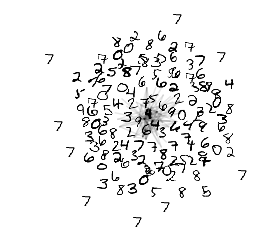

In [21]:
import networkx as nx
from networkx.drawing import spring_layout
#G = nx.Graph(layer_adj_matrix)
G = nx.Graph(layer_adj_matrix, width=layer_adj_matrix)
# nx.drawing.nx_pylab.draw_spring(G, node_size=40)
layout = spring_layout(G)

fig = plt.Figure()
# Generate the image
for i in range(128):
    for j in range(128):
        if layer_adj_matrix[i,j]>0.6:
            pos1 = layout[i]*100
            pos2 = layout[j]*100
            plt.plot([pos1[0], pos2[0]], [pos1[1], pos2[1]], alpha=0.05, color="black")
        
for i in range(128):
    pos = layout[i]*200
    extent = [pos[0]-14, pos[0]+14, pos[1]-14, pos[1]+14]
    img = X_test[repr_indices[i]][0].copy()
#     # add a black border
#     for i in range(len(img)):
#         img[i][0] = 1
#         img[i][-1] = 1
#         for j in range(len(img[0])):
#             img[0][j] = 1
#             img[-1][j] = 1
    img = np.ma.masked_where(img == 0, img)
    plt.imshow(img, interpolation="nearest", extent=extent, cmap="binary")
plt.autoscale()
plt.axis("off")
plt.show()

(28, 28)


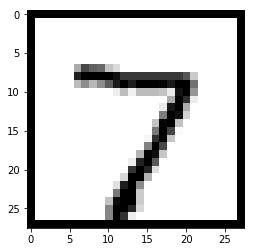

In [135]:
img = X_test[0][0]
# add a black border
for i in range(len(img)):
    img[i][0] = 1
    img[i][-1] = 1
    for j in range(len(img[0])):
        img[0][j] = 1
        img[-1][j] = 1
plt.imshow(img, cmap="binary")
print(img.shape)